# Week 5: Networks IV, advanced measures
02/10/2019
***

## Part A: Visualize the house of representatives network
***

### __Exercise 1: Pick one of the houses of representatives and build the network.__
- __Use NetworX `DiGraph` to store the network. Store also the properties of the nodes (state and party of each politician).__

For this exercise, the results from week 4 are used. The 115th congress is chosen.

In [1]:
# Package imports 
import pandas as pd
import io
import re
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from fa2 import ForceAtlas2
from scipy import stats

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the csv-file for the 115th congress
df = pd.read_csv('../week4/H115.csv',encoding = 'utf-8')

# Create empty digraph
G = nx.DiGraph()

# Create list of party and states
parties = list(df['Party'])
states = list(df['State'])

# Nodes are added
G.add_nodes_from(list(df['WikiPageName']))

# Each node is given an empty 'party' and 'state' attribute
nx.set_node_attributes(G,[],'party')
nx.set_node_attributes(G,[],'state')

In [3]:
# For-loop over all members.
# The current member's party and state is added as an attribute
# Her wiki-page is opened and all links are found. If any of these link point to any
# of the other members in the network, a directed edge is drawn.

for i in range(df.WikiPageName.sort_values().size):
    # Current node is read as the first element from the dataframe
    cnode = df.WikiPageName.iloc[i]
    
    # Party and state is added
    G.nodes[cnode]['party'] = parties[i]
    G.nodes[cnode]['state'] = states[i]
    
    # Folder path for current congress
    path_folder = '../week4/congress15/'
    
    # File is opened
    f = io.open(path_folder+cnode+'.txt','r',encoding = 'utf-8').read()
    
    # The wikilinks in the current wikipage are found
    links = re.findall(r'\[{2}(.*?)[\]{2}\|]',f)
    
    # Formatting of wikilinks
    links = [i.replace(' ', '_') for i in links]
    
    # Loop that adds a directed edge between current node and other nodes
    # if a link is present.
    for link in links:
        if link in G.nodes():
            G.add_edge(cnode, link)

### __Exercise 2: Visualize the network of the house of representatives.__
- __Try to visualise the network, using Networkx `draw spring`. Do you think it looks nice?__

In [4]:
# nx.draw_spring(G, node_size = 40, with_labels=False, node_color='#f58a00', alpha=0.5)

<font color="#0B498F"> The visualization is extremely cluttered and it is close to impossible to make any meaningful observations from it.

- __To achieve a better layout, you can use the `force atlas 2 algorithm` to determine the positions of the nodes.__

In [4]:
# Creates object 
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.0,

                        # Performance
                        jitterTolerance=0.01,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=10.0,
                        strongGravityMode=False,
                        gravity=0.0,

                        # Log
                        verbose=True)

# Calculates the positions using the object and the graph

# Using undirected graph for better visualisation
Gcop = G.to_undirected()

positions = forceatlas2.forceatlas2_networkx_layout(Gcop,pos=None,iterations=2000)

100%|██████████| 2000/2000 [00:04<00:00, 457.59it/s]

BarnesHut Approximation  took  1.11  seconds
Repulsion forces  took  2.82  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


- __Visualize the network using the `Networkx draw function`, and node coordinates form the force atlas algorithm. Plot nodes in different colors, according to their party. You can also set the nodes' size proportional to their degree.__
- __Play with the force atlas algorithm parameters to obtain a visualizatino you like. Hint: Using the undirected version of the graph you may get better visualizations.__

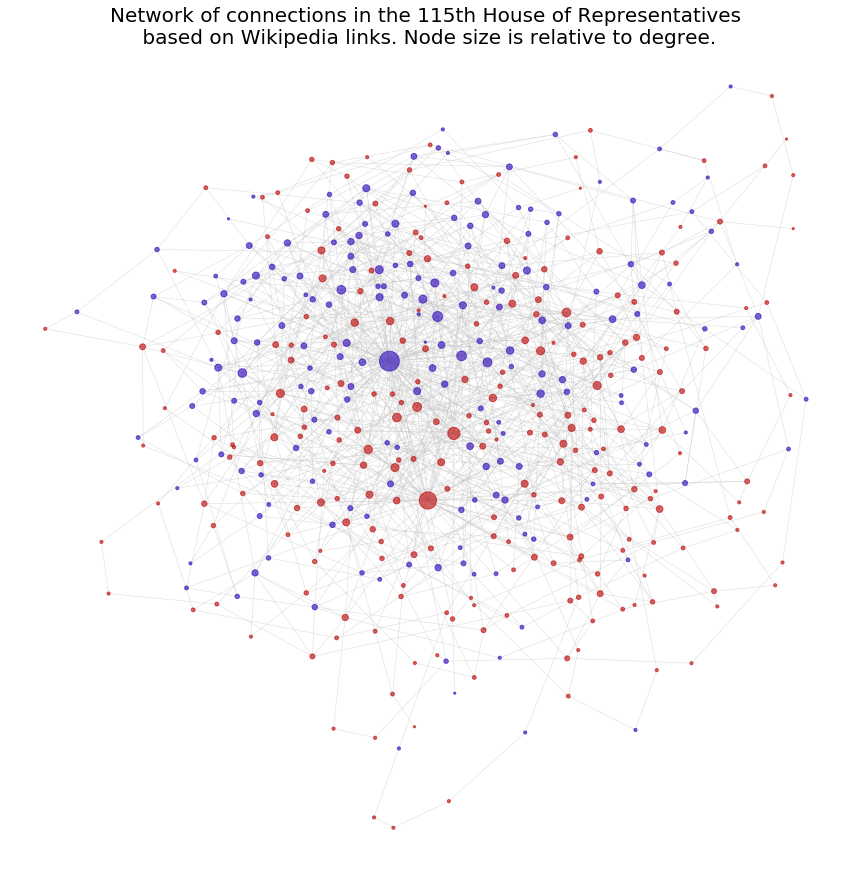

In [8]:
def color_mapping(value):
    if value == 'Democratic': return "#2800ba"
    else: return "#bd0000"

color_map = [color_mapping(node) for node in list(nx.get_node_attributes(Gcop,'party').values())]

f = plt.figure(figsize=(15, 15))
ax = f.gca()
d = dict(nx.degree(Gcop))
nx.draw(Gcop, pos=positions, node_size=[v * 5 for v in d.values()], with_labels=False, node_color=color_map, alpha=0.6,arrowsize=1,width=0.5,edge_color='#c4c4c4')
plt.title("Network of connections in the 115th House of Representatives\n based on Wikipedia links. Node size is relative to degree.",fontsize=20)
plt.show()

- __Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes?__


<font color="#0B498F"> What is immediately visible, is that there are two prominent members of the house: one Republican and one Democrat. These two persons are probably prominent members of their parties. These are connected to other members that also have a high number of connections, suggesting a hierarchy in the parties. There are indeed chains of connected nodes; these are mostly visible in the periphery of the structure.

In [7]:
degrees = np.array(list(dict(G.degree()).values()))
ind = np.argpartition(degrees, -2)[-2:]
names = [list(dict(nx.degree(G)))[i] for i in ind]
names = [name.replace('_',' ') for name in names]
print("Most connected people are {} and {}.".format(names[0], names[1]))

Most connected people are Paul Ryan and Nancy Pelosi.


### __Exercise 3: Investigate the reasons for links between politicians to exist on Wikipedia.__
- __Consider the node with the highest out-degree in the network. Open the corresponding Wikipedia page.__

In [8]:
degrees = list(dict(G.out_degree()).values())
idx_sort = np.argsort(degrees)
node_names = list(dict(G.out_degree()))

# Node with highest out-degree:
idx = idx_sort[-1]
# Name of this node
node_idx = node_names[idx]

print("Wikipage of member that contains the most outward going links is {} with {} links.".format(node_idx,degrees[idx] ))

Wikipage of member that contains the most outward going links is Kevin_McCarthy_(California_politician) with 19 links.


<font color="#0B498F"> Kevin McCarthy is the current House Minority Leader, and he has previously served as House Majority Leader.

- __Consider the set of neighbours of the node found above. Look for them in the page.__
- __What is the relation between the politician you identified and his/her network neighbours? (e.g. they work together, they come from the same town, they are opponents...)__

In [9]:
# Neighbours are found
neighbours = list(G.neighbors(node_idx))
print("{}'s neigbours in the network are: \n{}".format(node_idx, neighbours))

Kevin_McCarthy_(California_politician)'s neigbours in the network are: 
['Steve_Scalise', 'Nancy_Pelosi', 'Paul_Ryan', 'Steny_Hoyer', 'Jim_Clyburn', 'Jim_Jordan_(American_politician)', 'Kevin_Yoder', 'Pete_Sessions', 'Jeb_Hensarling', 'Cathy_McMorris_Rodgers', 'Trey_Gowdy', 'Dana_Rohrabacher', 'Clay_Higgins', 'John_Garamendi', 'Jared_Huffman', 'Mike_Thompson_(California_politician)', 'Devin_Nunes', 'Dave_Loebsack', 'Jerry_McNerney']


<font color="#0B498F"> Several of the names in the list are people that have held the same positions as Kevin, or people who succeeded him. The people are primarily coworkers in some sense of the word. Some are from the same party - others are in the opposition.

- __Repeat the exercise for the second largest out-degree node. Write down possible reasons why links exist between Wikipedia pages of politicians. Do all the links carry the same meaning?__

In [10]:
idx2 = idx_sort[-2]
node_idx2 = node_names[idx2]
print("Wikipage of member that contains the second most outward going links is {} with {} links.".format(node_idx2.replace('_',' '),degrees[idx2]))

Wikipage of member that contains the second most outward going links is Ro Khanna with 18 links.


<font color="#0B498F"> Possible reasons why links exist between Wikipedia pages of politicians:
- The two politicians might have shared the same position, e.g., House Majority Leader 
- The two politicians might share opinions on a subject - or the opposite
- The two politicians might have run for office or another position at the same time
- The two politicians might be friends/enemies
    
The links definitely don't carry the same meaning, though this phrasing is somewhat arbitrary. If a person has sought a position many times, that person is likely to have many in and outgoing links.

- __Based on the observations above, can you partly explain the structure observed in exercise 2?__

<font color="#0B498F"> Most American politicians that hold some position in office are not expected to continue holding this position. This means that they will be preceded and succeded by other politicians, thereby creating links between their Wikipedia pages. Similarly, some politicians, such as Paul Ryan or Nancy Pelosi, have held many different positions, greatly increasing their total degree-count. The more active and diverse a politician is in her political life, the more connected she will be, which is what is reflected from the above illustration.
    
This need not be the case though. Many politicians who serve more supportive roles, such as Ro Khanna, will have many outgoing links, whereas the politicians who are themselves supported may have more ingoing links. Only looking at outgoing links is not a suffcient to describe the overall tendency.

## Part B: The structure of the house of representatives network
***

### Exercise 4: Begin to analyze the network of the house of representatives

- __Why do you think I want you guys to use a directed graph? Could have we used an undirected graph instead?__
<font color="#0B498F"> A directed graph holds more information. A central politician in a party is likely to be mentioned many times by other politicians. It is however not equally likely that the politician herself will mention all that mention her. We could have used an undirected graph yes, but the outcome would be different, and some information would be lost or simply unavailable. </font>

    
- __What is the total number of nodes in the network? What is the total number of links? The density of the network?__

In [11]:
num_nodes = G.number_of_nodes()
num_links = G.number_of_edges()
net_density = nx.density(G)
print(f"Number of nodes: {num_nodes}\nNumber of links: {num_links}\nNetwork density: {net_density:.2}")

Number of nodes: 445
Number of links: 1784
Network density: 0.009


- __What are the average, median, mode, minimum, maximum, value of the in-degree? And the out-degree? How do you interpret the results?__

In [12]:
# Extraction of degrees
indegrees = list(dict(G.in_degree()).values())
outdegrees = list(dict(G.out_degree()).values())

# Summary statistics
in_mean = np.mean(indegrees)
out_mean = np.mean(outdegrees)

in_med = np.median(indegrees)
out_med = np.median(outdegrees)

in_mod = stats.mode(indegrees)[0][0]
out_mod = stats.mode(outdegrees)[0][0]

in_min = np.min(indegrees)
out_min = np.min(outdegrees)

in_max = np.max(indegrees)
out_max = np.max(outdegrees)

print("Summary statistics for the in-degree:\nMean \t\t= {:.3}\nMedian \t\t= {}\nMode \t\t= {}\nMinimum \t= {}\nMaximum \t= {}".format(in_mean,in_med,in_mod,in_min,in_max))
print("\nSummary statistics for the out-degree:\nMean \t\t= {:.3}\nMedian \t\t= {}\nMode \t\t= {}\nMinimum \t= {}\nMaximum \t= {}".format(out_mean,out_med,out_mod,out_min,out_max))

Summary statistics for the in-degree:
Mean 		= 4.01
Median 		= 3.0
Mode 		= 2
Minimum 	= 0
Maximum 	= 71

Summary statistics for the out-degree:
Mean 		= 4.01
Median 		= 3.0
Mode 		= 2
Minimum 	= 0
Maximum 	= 19


<font color="#0B498F"> As is clear from the above summary statistics, the in- and out-degrees are very similar. The only difference is the maximum values: one node has 71 mentions in other Wikipedia articles, while another mentions 19 other politicians. 
    
On average, a politican is mentioned around 4 times, while she herself mentions other politicians 4 times.

- __List the top 5 politicians by in-degree and out-degree. What is their party and state? Do these politicians play a particular role in the house?__

In [13]:
# Extraction of degrees
indegrees = list(dict(G.in_degree()).values())
outdegrees = list(dict(G.out_degree()).values())

# Sorting of the lists and extraction of indices
idx_in_sort = np.argsort(indegrees)
idx_out_sort = np.argsort(outdegrees)

# Names are saved for easy usage
node_names = list(dict(G.out_degree()))

# Top 5 node indices are saved
in_top5 = np.flip(idx_in_sort[-5:])
out_top5 = np.flip(idx_out_sort[-5:])



# Names
names_in_top5 = [node_names[i] for i in in_top5]
names_out_top5 = [node_names[i] for i in out_top5]
# print(f"Top 5 politicians by in-degree:\n{names_in_top5}")
# print(f"\nTop 5 politicians by out-degree:\n{names_out_top5}")

print("Top 5 in-degrees:\n")
for i,j in zip(range(5), in_top5):
    print("Top {} politician:".format(i+1))
    print("Name \t{}".format(names_in_top5[i]))
    print("Party: \t{}".format(df.Party[j]))
    print("State: \t{}\n".format(df.State[j]))

print("\nTop 5 out-degrees:\n")
for i,j in zip(range(5), out_top5):
    print("Top {} politician:".format(i+1))
    print("Name \t{}".format(names_out_top5[i]))
    print("Party: \t{}".format(df.Party[j]))
    print("State: \t{}\n".format(df.State[j]))

Top 5 in-degrees:

Top 1 politician:
Name 	Nancy_Pelosi
Party: 	Democratic
State: 	California

Top 2 politician:
Name 	Paul_Ryan
Party: 	Republican
State: 	Wisconsin

Top 3 politician:
Name 	Kevin_McCarthy_(California_politician)
Party: 	Republican
State: 	California

Top 4 politician:
Name 	Steny_Hoyer
Party: 	Democratic
State: 	Maryland

Top 5 politician:
Name 	Ed_Royce
Party: 	Republican
State: 	California


Top 5 out-degrees:

Top 1 politician:
Name 	Kevin_McCarthy_(California_politician)
Party: 	Republican
State: 	California

Top 2 politician:
Name 	Ro_Khanna
Party: 	Democratic
State: 	California

Top 3 politician:
Name 	Nancy_Pelosi
Party: 	Democratic
State: 	California

Top 4 politician:
Name 	Cathy_McMorris_Rodgers
Party: 	Republican
State: 	Washington

Top 5 politician:
Name 	Brad_Sherman
Party: 	Democratic
State: 	California



<font color="#0B498F"> 
- Ed Royce: Chair of Foreign Affairs
- Steny Hoyer: Minority Whip
- Kevin McCarthy: Majority Leader
- Paul Ryan: Speaker of the House
- Nancy Pelosi: Minority Leader

- Brad Sherman: N/A
- Cathy McMorris Rodgers: Republican Conference Chairwoman
- Ro Khanna: N/A

Almost all have prominent positions.

- __Plot the distribution of in-degrees and out-degrees. What is the most common in-degree? What is the most common out-degree?__

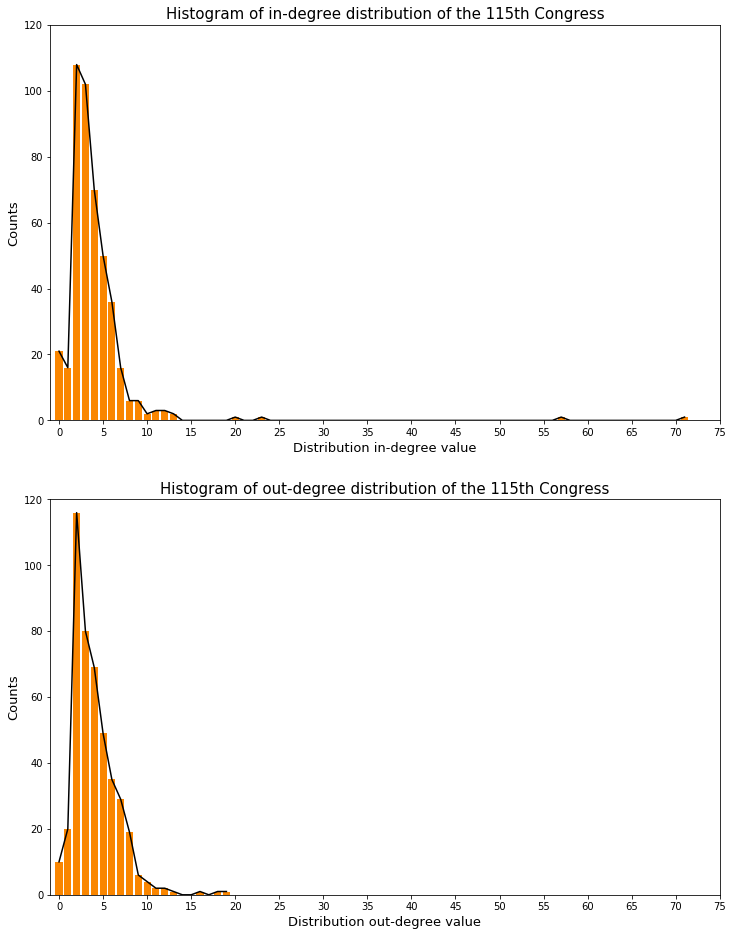

In [14]:
indegrees = list(dict(G.in_degree()).values())
outdegrees = list(dict(G.out_degree()).values())
vin = np.arange(min(indegrees)-0.5, max(indegrees)+1.5)
vout = np.arange(min(outdegrees)-0.5, max(outdegrees)+1.5)
incounts, inbin_edges = np.histogram(indegrees,vin)
outcounts, outbin_edges = np.histogram(outdegrees,vout)

# Middle points of the bin-edges are again calculated.
inx_bins = [np.mean((inbin_edges[i],inbin_edges[i+1])) for i in range(len(inbin_edges)-1)]
outx_bins = [np.mean((outbin_edges[i],outbin_edges[i+1])) for i in range(len(outbin_edges)-1)]

# Figure creation
f = plt.figure(figsize=(12, 16))
ax = f.gca()

# Top plot
plt.subplot(2,1,1)
plt.bar(inx_bins,incounts,color='#fa8600',alpha = 1,label='In-degree')
plt.plot(inx_bins,incounts,color='k')

# Plot options
plt.title('Histogram of in-degree distribution of the 115th Congress', fontsize=15)
plt.xlabel("Distribution in-degree value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.xticks(np.arange(0,85,5))
plt.ylim([0,120])
plt.xlim([-1,75])

# Bottom plot.
plt.subplot(2,1,2)
plt.bar(outx_bins,outcounts,color='#fa8600',alpha = 1,label='Out-degree')
plt.plot(outx_bins,outcounts,color='k')

# Plot options
plt.title('Histogram of out-degree distribution of the 115th Congress', fontsize=15)
plt.xlabel("Distribution out-degree value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.xticks(np.arange(0,85,5))
plt.ylim([0,120])
plt.xlim([-1,75])

plt.show()

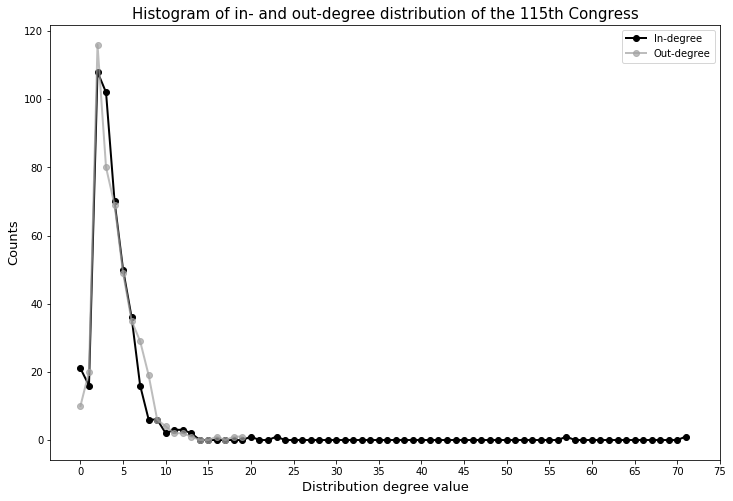

In [15]:
# Figure creation
f = plt.figure(figsize=(12, 8))
ax = f.gca()

# Plotting
plt.plot(inx_bins,incounts,color='k',label='In-degree',linewidth=2,marker='o')
plt.plot(outx_bins,outcounts,color='#a1a1a1',linewidth='2',label='Out-degree',alpha=0.7,marker='o')

# Plot options
plt.title('Histogram of in- and out-degree distribution of the 115th Congress', fontsize=15)
plt.xlabel("Distribution degree value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.xticks(np.arange(0,80,5))

plt.legend()

plt.show()

<font color="#0B498F"> Most common in-degree is 3, while the most common out-degree is 2.    
</font>

- __Plot the probability distribution of in-degrees and out-degree one more time, this time plotted in loglog-scale.__

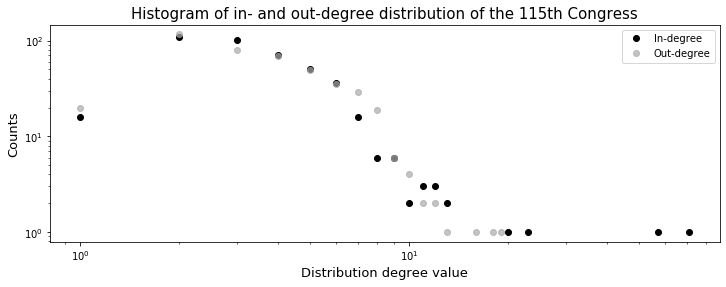

In [16]:
# Figure creation
f = plt.figure(figsize=(12, 4))
ax = f.gca()

# Plotting
plt.loglog(inx_bins,incounts,'o',color='k',label='In-degree',linewidth=2)
plt.loglog(outx_bins,outcounts,'o',color='#aaaaaa',linewidth='2',label='Out-degree',alpha=0.7)

# Plot options
plt.title('Histogram of in- and out-degree distribution of the 115th Congress', fontsize=15)
plt.xlabel("Distribution degree value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
# plt.xticks(np.arange(0,80,5))

plt.legend()

plt.show()

- __Describe the distributions (as you would in a well written figure caption). Do they look Poissonian? Power-law? Something in between?__

<font color="#0B498F"> The two degree distributions look fairly similar. The only major difference between the two is that the maximum value of the in-degree is somewhat larger than for the out-degree. It is not unreasonable to describe the distributions as belonging to a power-law distribution as they both look fairly linear in the above loglog-plot. They both, however, have outlier values centered around degree values of 1. 
</font>

- __Plot a scatter plot of the the in- versus out- degree for all politicians. Comment on the relation between the two.__

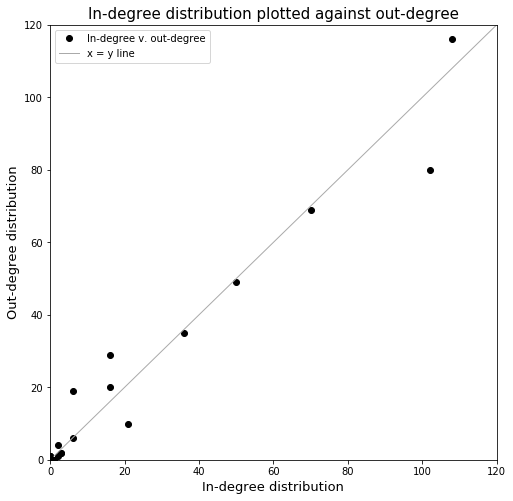

In [17]:
# Figure creation
f = plt.figure(figsize=(8, 8))
ax = f.gca()

# Zero-padding of the out-degrees to get equal lengths of the vectors
out_zero = np.zeros(incounts.size)
for i in range(outcounts.size):
    out_zero[i] = outcounts[i]
    
# Plotting
plt.plot(incounts,out_zero,'o',color='k',linewidth=2,label="In-degree v. out-degree")
plt.plot(np.linspace(1,120,200),np.linspace(1,120,200),color='#aaaaaa',linewidth=1,label="x = y line")

# Plot options
plt.title('In-degree distribution plotted against out-degree', fontsize=15)
plt.xlabel("In-degree distribution", fontsize=13)
plt.ylabel("Out-degree distribution", fontsize=13)
plt.xlim([0,120])
plt.ylim([0,120])
plt.legend()

plt.show()

<font color="#0B498F"> There definitely seems to be a linear relationship between the in- and out-degrees. To easily see this, a straight line where $x = y$ has been plotted. The dots fall fairly close to this line indicating a close to 1-to-1 ratio.
</font>

- __Plot a heatmap of the in- versus out-degree for all politicians. What is the advantage of using a heatmap?__

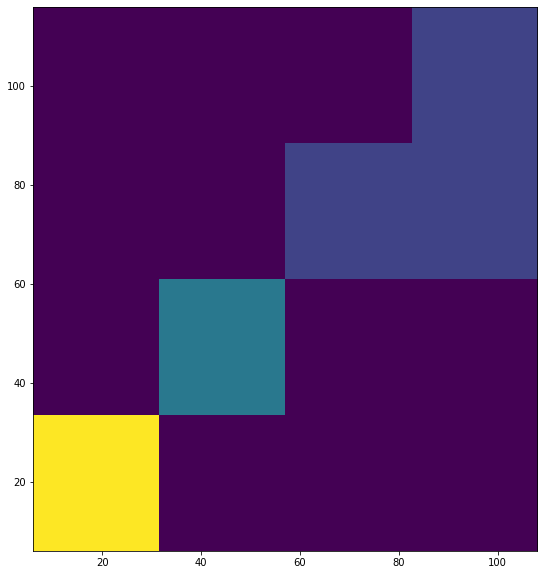

In [18]:
heatmap, xedges, yedges = np.histogram2d(incounts[:10],outcounts[:10], bins = 4)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

f = plt.figure(figsize=(10, 10))
ax = f.gca()
plt.imshow(heatmap.T, extent = extent, origin='lower')
plt.show()

### Exercise 5: Going in depth with the structure of the House of Representatives

- __Not all of the measures we'll be considering below are defined for directed graphs, thus begin by creating an undirected version of the graph, that we can use whenever needed. Only use the undirected graph when explicitly stated in the exercise.__

In [19]:
# The GCC of the directed network is extracted
Gweak = max(nx.weakly_connected_component_subgraphs(G, copy=True),key=len)

# An undirected copy is created
Gundir = Gweak.to_undirected()

- __Find the 5 most central politicians according to betweenness centrality. What role do you imagine politicians with high wikipedia graph betweenness centrality play?__

In [20]:
# Politician names are saved for easy access
node_names = list(df['WikiPageName'])

# Centrality is calculated
cen_bet = list(nx.betweenness_centrality(Gweak).values())

# Sorted indices are saved and reversed to get decreasing order.
idx_cen_bet = np.flip(np.argsort(cen_bet))

# Top five is saved
cen_bet_top5 = [node_names[i] for i in idx_cen_bet[:5]]
cen_bet_top5 = '\n'.join(cen_bet_top5)

print("Five most central politicians according to betweenness centrality is:\n{}".format(cen_bet_top5))

Five most central politicians according to betweenness centrality is:
Nancy_Pelosi
Kevin_McCarthy_(California_politician)
Paul_Ryan
Devin_Nunes
Steny_Hoyer


<font color="#0B498F"> Betweenness centrality is a measure of which nodes in a network the shortest paths go through. The most central nodes according to this definition will be probably be the highest ranking party members, such as Majority/Minority leaders, Speaker of the House etc. This is the case since these people are the communicators between their own party members and the members of the opposing party.
</font>

- __Find the 5 most central politicians according to eigenvector centrality. Calculate the centrality corresponding to both in- and out-edges.__

In [21]:
# Centrality is calculated.
# For the out-edges, the input graph is reversed as per the documentation.
cen_eig_in = list(nx.eigenvector_centrality(Gweak).values())
cen_eig_out = list(nx.eigenvector_centrality(Gweak.reverse()).values())

# Sorted indices are saved
idx_cen_eig_in = np.argsort(cen_eig_in)
idx_cen_eig_out = np.argsort(cen_eig_out)

# Top five is saved and reversed so the order is increasing
cen_eig_in_top5 = [node_names[i] for i in idx_cen_eig_in[-5:]]
cen_eig_out_top5 = [node_names[i] for i in idx_cen_eig_out[-5:]]
cen_eig_in_top5.reverse()
cen_eig_in_top5 = '\n'.join(cen_eig_in_top5)
cen_eig_out_top5.reverse()
cen_eig_out_top5 = '\n'.join(cen_eig_out_top5)

print("Five most central politicians according to eigenvalue centrality (in) is:\n{}".format(cen_eig_in_top5))
print("\nFive most central politicians according to eigenvalue centrality (out) is:\n{}".format(cen_eig_out_top5))


Five most central politicians according to eigenvalue centrality (in) is:
Nancy_Pelosi
Kevin_McCarthy_(California_politician)
Paul_Ryan
Steny_Hoyer
Steve_Scalise

Five most central politicians according to eigenvalue centrality (out) is:
Kevin_McCarthy_(California_politician)
Devin_Nunes
Jim_Clyburn
Trey_Hollingsworth
Nancy_Pelosi


- __Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why?__

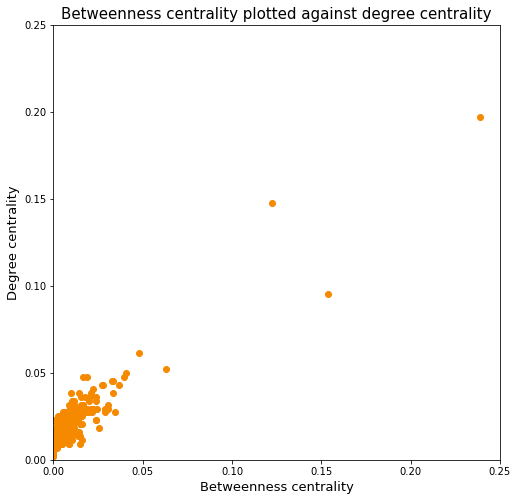

In [22]:
# Degree centrality is calculated
degree_cen = list(nx.degree_centrality(Gweak).values())

# Figure creation
f = plt.figure(figsize=(8, 8))
ax = f.gca()

# Plotting
# plt.plot(cen_bet, degree_cen,color='#f58a00',linewidth=4)
plt.plot(cen_bet, degree_cen,'o',color='#f58a00',linewidth=2)

# Plot options
plt.title('Betweenness centrality plotted against degree centrality', fontsize=15)
plt.xlabel("Betweenness centrality", fontsize=13)
plt.ylabel("Degree centrality", fontsize=13)
plt.xlim([0,0.25])
plt.ylim([0,0.25])

plt.show()

<font color="#0B498F"> Degree centrality of a node is the fraction of the nodes it is connected to - a measure of how many connections it has. As can be seen in the plot, there appears to be a correlation between the betweenness centrality of a node and its degree centrality. The more central a node is, the more nodes it's connected to, which makes perfectly good sense.

- __Repeat the two points above using eigenvector centrality instead. Do you observe any difference? Why?__

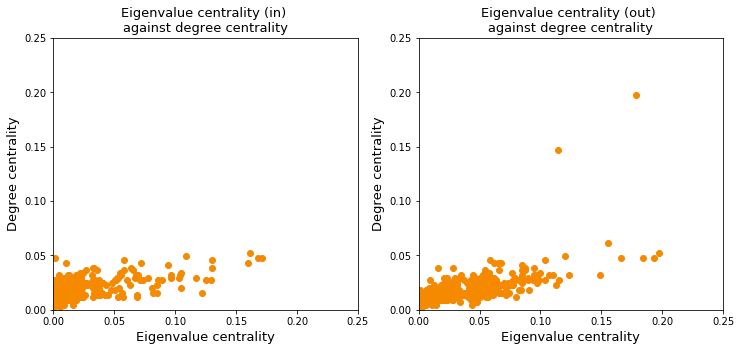

In [23]:
# Figure creation
f = plt.figure(figsize=(12, 5))
ax = f.gca()

# Plotting
# plt.plot(cen_bet, degree_cen,color='#f58a00',linewidth=4)

plt.subplot(1,2,1)
plt.plot(cen_eig_in, degree_cen,'o',color='#f58a00',linewidth=2)

# Plot options
plt.title('Eigenvalue centrality (in) \nagainst degree centrality', fontsize=13)
plt.xlabel("Eigenvalue centrality", fontsize=13)
plt.ylabel("Degree centrality", fontsize=13)
plt.xlim([0,0.25])
plt.ylim([0,0.25])


plt.subplot(1,2,2)
plt.plot(cen_eig_out, degree_cen,'o',color='#f58a00',linewidth=2)

# Plot options
plt.title('Eigenvalue centrality (out) \nagainst degree centrality', fontsize=13)
plt.xlabel("Eigenvalue centrality", fontsize=13)
plt.ylabel("Degree centrality", fontsize=13)
plt.xlim([0,0.25])
plt.ylim([0,0.25])

plt.show()

<font color="#0B498F"> Eigenvalue centrality is a measure of how 'important' or 'significant' a node is. If a node has a neighbour with a very high degree, the current node will have a higher eigenvalue centrality value. Above we see that there is a correlation between the eigenvalue centrality and the degree centrality of a node. This is not suprising. In networks, we often see that 'high-value members' are directly connected to other such members - they're grouped together. This explains the correlation. 

- __Is the undirected version of the graph assortative with respect do degree? (e.g. do high-degree politicians tend to link to other high-degree politicians, and low-degree politicians to other low-degree politicians?). Provide an interpretation of your answer.__

In [24]:
#Compute degree assortativity for undirected and directed networks
deg_ass_un = nx.degree_assortativity_coefficient(Gundir)
deg_ass_dir = nx.degree_assortativity_coefficient(Gweak)

# Print the results
print(f"Degree assortativity for the undirected graph is {deg_ass_un:.2}.")
print(f"Degree assortativity for the directed graph is {deg_ass_dir:.2}.")

Degree assortativity for the undirected graph is -0.0083.
Degree assortativity for the directed graph is 0.1.


<font color="#0B498F"> According to the above results, the undirected graph is _not_ assortative with respect to degree, unlike the directed graph. When considering the dataset at hand, this is not too surprising. 
    
Let's first consider the directed graph: 
This network shows which politicians mention which. We expect the politicians in positions of power to be mentioned many times, i.e., they will have many edges terminating in them, and their degree will generally be high. They do, however, not themselves link to all other politicians that link to them. Thus the directed network is assortative: higher ranking politicians are more likely to link to other higher ranking politicians.
    
    
    
For the undirected network, the case is different. Now there are edges drawn between the high ranking politicians and all that mention them. The assortativity constant will thus be close to zero, which is what we observe.</font>

- __What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes and p?__

In [25]:
# Average shortest path length is computed
G_path = nx.average_shortest_path_length(Gweak)
print(f"Average shortest path length of the network is {G_path:.3}")

# Random network of similar characteristics is created:
N = df.shape[0]
k = sum(list(dict(Gweak.degree()).values()))/N
p = k/(N-1)
G_rand = nx.erdos_renyi_graph(N,p)
G_random_path = nx.average_shortest_path_length(G_rand)
print(f"Average shortest path length of the random network is {G_random_path:.3}")

Average shortest path length of the network is 4.5
Average shortest path length of the random network is 3.15


<font color="#0B498F"> The shortest path is somewhat longer than for a random graph with similar p and N.
</font>

### Exercise 6: Parties and nodes centrality

- __Compute the average node centrality for Democratic and Republican member of the house using your favourite centrality measure.__

In [39]:
# Parties are saved as a list.
parties = list(nx.get_node_attributes(Gweak,'party').values())

cen_eig_in = list(nx.eigenvector_centrality(Gweak).values())
cen_bet = list(nx.betweenness_centrality(Gweak).values())


# Empty list are initialised that will contain the betweenness centrality values
cen_bet_Dem = []
cen_bet_Rep = []
for num, par in zip(cen_eig_in, parties):
    if par == 'Democratic':
        cen_bet_Dem.append(num)
    else:
        cen_bet_Rep.append(num)
cen_bet_Dem_mean = np.mean(cen_bet_Dem)
cen_bet_Rep_mean = np.mean(cen_bet_Rep)
print(f"Average node centrality for Democrats: \t\t{cen_bet_Dem_mean:.3}")
print(f"Average node centrality for Republicans: \t{cen_bet_Rep_mean:.3}")

Average node centrality for Democrats: 		0.0246
Average node centrality for Republicans: 	0.0191


- __Create a new graph, with the same nodes and edges, but where the association between nodes and parties is shuffled. Compute the average centrality of Republicans and Democrats nodes for this randomized graph.__

In [40]:
# A copy of the original unrected graph is created, since the given method isn't
# implemented for directed graphs

Gundir_rand = Gundir.copy()
for i in range(2*len(Gundir_rand.edges())):
    # Following function repositions an edge in the network randomly
    nx.double_edge_swap(Gundir_rand)
    
# Average centrality for this network is calculated:
# cen_bet_rand = list(nx.betweenness_centrality(Gundir_rand).values())
cen_bet_rand = list(nx.eigenvector_centrality(Gundir_rand).values())

temp_dem = []
temp_rep = []

# Values are appended to their respective lists.
for num, par in zip(cen_bet_rand, parties):
    if par == 'Democratic':
        temp_dem.append(num)
    else:
        temp_rep.append(num)
        
# Means are calculated.
random_dem_mean = np.mean(temp_dem)
random_rep_mean = np.mean(temp_rep)

print("Average centrality for Republicans in the randomized graph:\n{:.2}".format(random_rep_mean))
print("Average centrality for Democrats in the randomized graph:\n{:.2}".format(random_dem_mean))

Average centrality for Republicans in the randomized graph:
0.027
Average centrality for Democrats in the randomized graph:
0.033


- __Repeat the point above 100 times (at least) and plot two histograms with the values of centrality obtained for Republicans and Democrats.__

In [41]:
# Initialize empty numpy array of correct size
cen_bet_rand = np.zeros(len(Gundir.nodes()))

# Do the below 100 times
for j in range(100):
    # Copy of original network
    Gundir_rand = Gundir.copy()
    # Swap ~2400 edges in the network
    for i in range(2*len(Gundir_rand.edges())):
        # Following function repositions an edge in the network randomly
        nx.double_edge_swap(Gundir_rand)

    # Calculate centrality and add it to the array 
    # cen_bet_rand += np.array(list(nx.betweenness_centrality(Gundir_rand).values()))
    cen_bet_rand += np.array(list(nx.eigenvector_centrality(Gundir_rand).values()))

# Normalize the array to get the averaged distribution
cen_bet_rand = np.divide(cen_bet_rand,j)

In [42]:
# The centrality values are divided into their parties
cen_dem = []
cen_rep = []

# Values are appended to their respective lists.
for num, par in zip(cen_bet_rand, parties):
    if par == 'Democratic':
        cen_dem.append(num)
    else:
        cen_rep.append(num)
        
# Means are calculated.
random_dem_mean = np.mean(cen_dem)
random_rep_mean = np.mean(cen_rep)

print("Average eigenvalue centrality for Republicans in the randomized graph:\n{:.2}".format(random_rep_mean))
print("Average eigenvalue centrality for Democrats in the randomized graph:\n{:.2}".format(random_dem_mean))

Average eigenvalue centrality for Republicans in the randomized graph:
0.028
Average eigenvalue centrality for Democrats in the randomized graph:
0.033


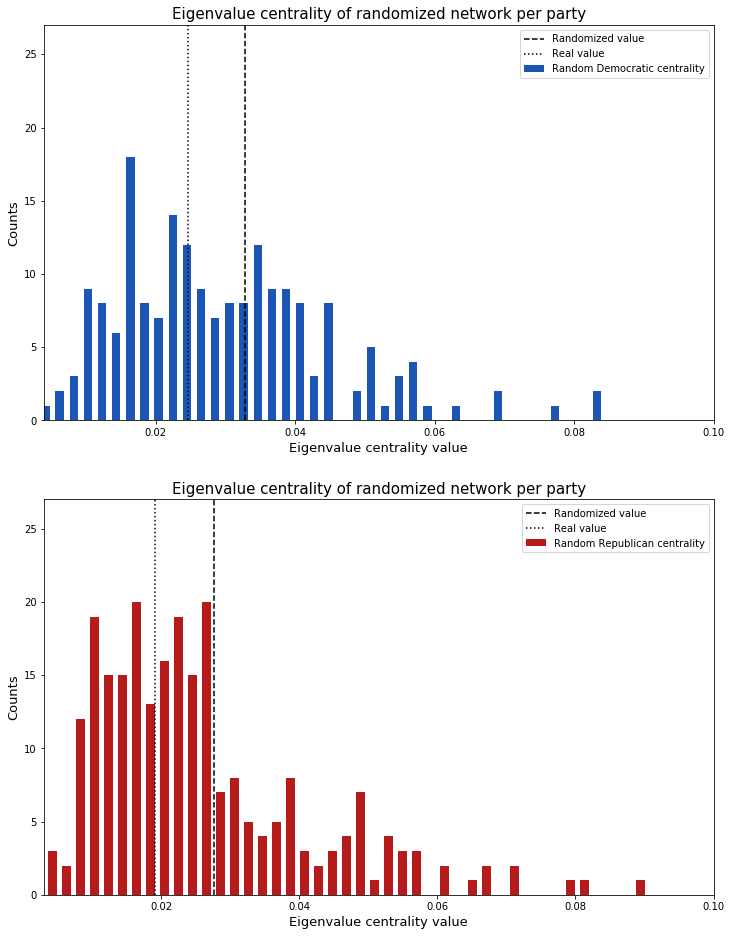

In [43]:
vdem = np.linspace(min(cen_dem), max(cen_dem),len(cen_dem))
vrep = np.linspace(min(cen_rep), max(cen_rep),len(cen_rep))

v = np.linspace(min(min(cen_dem),min(cen_rep)), max(max(cen_dem),max(cen_rep)),max(len(cen_dem),len(cen_rep)))

cen_demcounts, cen_dembin_edges = np.histogram(cen_dem,v)
cen_repcounts, cen_repbin_edges = np.histogram(cen_rep,v)

# Middle points of the bin-edges are again calculated.
cen_demx_bins = [np.mean((cen_dembin_edges[i],cen_dembin_edges[i+1])) for i in range(len(cen_dembin_edges)-1)]
cen_repx_bins = [np.mean((cen_repbin_edges[i],cen_repbin_edges[i+1])) for i in range(len(cen_repbin_edges)-1)]

# Figure creation
f = plt.figure(figsize=(12, 16))
ax = f.gca()

# Top plot
plt.subplot(2,1,1)
plt.bar(cen_demx_bins,cen_demcounts,color='#1b56b5',label='Random Democratic centrality',width=0.0012)
plt.axvline(x=random_dem_mean,color='k',linestyle = '--',label='Randomized value')
plt.axvline(x=cen_bet_Dem_mean,color='k',linestyle=':',label='Real value')
#plt.plot(cen_demx_bins,cen_demcounts,color='k')
# plt.bar(cen_demx_bins,cen_demcounts)

# Plot options
plt.title('Eigenvalue centrality of randomized network per party', fontsize=15)
plt.xlabel("Eigenvalue centrality value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
# plt.xticks(np.arange(0,85,5))
plt.ylim([0,27])
plt.xlim([0.004,0.1])
plt.legend()

# Bottom plot.
plt.subplot(2,1,2)
plt.bar(cen_repx_bins,cen_repcounts,color='#b51b1b',alpha = 1,label='Random Republican centrality',width=0.0012)
plt.axvline(x=random_rep_mean,color='k',linestyle='--',label='Randomized value')
plt.axvline(x=cen_bet_Rep_mean,color='k',linestyle=':',label='Real value')
#plt.plot(cen_repx_bins,cen_repcounts,color='k')

# Plot options
plt.title('Eigenvalue centrality of randomized network per party', fontsize=15)
plt.xlabel("Eigenvalue centrality value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
# plt.xticks(np.arange(0,85,5))
plt.ylim([0,27])
plt.xlim([0.003,0.1])
plt.legend()


vdem = np.linspace(min(cen_dem), max(cen_dem),len(cen_dem))
vrep = np.linspace(min(cen_rep), max(cen_rep),len(cen_rep))
cen_demcounts, cen_dembin_edges = np.histogram(cen_dem,vdem)
cen_repcounts, cen_repbin_edges = np.histogram(cen_rep,vrep)

# Middle points of the bin-edges are again calculated.
cen_demx_bins = [np.mean((cen_dembin_edges[i],cen_dembin_edges[i+1])) for i in range(len(cen_dembin_edges)-1)]
cen_repx_bins = [np.mean((cen_repbin_edges[i],cen_repbin_edges[i+1])) for i in range(len(cen_repbin_edges)-1)]
plt.show()

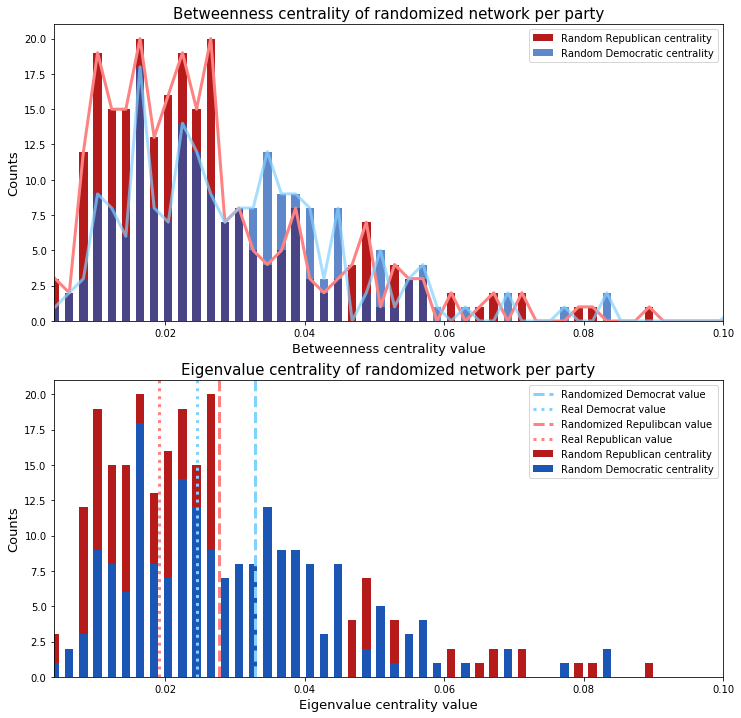

In [50]:
v = np.linspace(min(min(cen_dem),min(cen_rep)), max(max(cen_dem),max(cen_rep)),max(len(cen_dem),len(cen_rep)))
cen_demcounts, cen_dembin_edges = np.histogram(cen_dem,v)
cen_repcounts, cen_repbin_edges = np.histogram(cen_rep,v)

# Middle points of the bin-edges are again calculated.
cen_demx_bins = [np.mean((cen_dembin_edges[i],cen_dembin_edges[i+1])) for i in range(len(cen_dembin_edges)-1)]
cen_repx_bins = [np.mean((cen_repbin_edges[i],cen_repbin_edges[i+1])) for i in range(len(cen_repbin_edges)-1)]


# Figure creation
f = plt.figure(figsize=(12, 12))
ax = f.gca()

plt.subplot(2,1,1)

# Plots
plt.bar(cen_repx_bins,cen_repcounts,color='#b51b1b',alpha = 1.0,label='Random Republican centrality',width=0.0012)
plt.bar(cen_demx_bins,cen_demcounts,color='#1b56b5',alpha = 0.7,label='Random Democratic centrality',width=0.0012)
plt.plot(cen_repx_bins,cen_repcounts,color='#ff8282',linewidth=3)
plt.plot(cen_demx_bins,cen_demcounts,color='#82d1ff',linewidth=3, alpha = 0.7)

# Plot options
plt.title('Betweenness centrality of randomized network per party', fontsize=15)
plt.xlabel("Betweenness centrality value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.xlim([0.004,0.1])
plt.legend()

# Bottom plot.
plt.subplot(2,1,2)

# Plots
plt.bar(cen_repx_bins,cen_repcounts,color='#b51b1b',alpha = 1.0,label='Random Republican centrality',width=0.0012)
plt.bar(cen_demx_bins,cen_demcounts,color='#1b56b5',alpha = 1.0,label='Random Democratic centrality',width=0.0012)
plt.axvline(x=random_dem_mean,color='#82d1ff',linestyle = '--',label='Randomized Democrat value ', linewidth=3)
plt.axvline(x=cen_bet_Dem_mean,color='#82d1ff',linestyle=':',label='Real Democrat value', linewidth=3)
plt.axvline(x=random_rep_mean,color='#ff8282',linestyle='--',label='Randomized Repulibcan value', linewidth=3)
plt.axvline(x=cen_bet_Rep_mean,color='#ff8282',linestyle=':',label='Real Republican value', linewidth=3)

# Plot options
plt.title('Eigenvalue centrality of randomized network per party', fontsize=15)
plt.xlabel("Eigenvalue centrality value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.xlim([0.004,0.1])
plt.legend()

plt.subplot(2,1,2)

plt.show()

***
### Exercise 7: Assortativity with respect to parties and states
***

- __Consider the undirected version of the graph. For each node, compute the fraction of edges that connect to a node of his/her same party. Find the average value across all nodes.__


In [32]:
# Empty array of fractions is created
frac = np.zeros(len(Gundir.nodes()))

# For loop that iterates over all nodes and their index 
for node, i in zip(Gundir.nodes(),range(len(Gundir.nodes()))):
    # Index of current nodes neighbours
    
    
    temp_names = [n for n in Gundir.neighbors(node)]
    # True and false values are initialised to 0
    tt = 0
    ff = 0
    # If a neighbour belongs to the same party, tt is incremented. Else ff is.
    for name in temp_names:
        if Gundir.nodes[node]['party'] == Gundir.nodes[name]['party']:
            tt += 1
        else:
            ff += 1
    # Fraction is calculated and added to the array        
    frac[i] = tt / (tt+ff)
    
# Mean is calculated    
avg_frac = np.mean(frac)    
print("Average fraction of a node's neigbours belonging to his own party: {:.3}".format(avg_frac))

Average fraction of a node's neigbours belonging to his own party: 0.624


- __Create a new graph, with the same nodes and edges, but where the association between nodes and parties is shuffled. Compute the measure above for this randomized graph.__

In [33]:
# Copy of the undirected graph is created
Gun_cop = Gundir.copy()

# All parties in order is saved and shuffled
parties = np.array(list(df.Party.values))
np.random.shuffle(parties)

# For all nodes, their party is chosen as the i'th element in the shuffled
# list of parties.
for i, node in zip(range(len(parties)), Gun_cop.nodes()):
    Gun_cop.nodes[node]['party'] = parties[i]

# Empty array of fractions is created
rand_frac = np.zeros(len(Gundir.nodes()))


# For loop that iterates over all nodes and their index 
for node, i in zip(Gun_cop.nodes(),range(len(Gun_cop.nodes()))):
    # Index of current nodes neighbours
    
    
    temp_names = [n for n in Gun_cop.neighbors(node)]
    # True and false values are initialised to 0
    tt = 0
    ff = 0
    # If a neighbour belongs to the same party, tt is incremented. Else ff is.
    for name in temp_names:
        if Gun_cop.nodes[node]['party'] == Gun_cop.nodes[name]['party']:
            tt += 1
        else:
            ff += 1
    # Fraction is calculated and added to the array        
    rand_frac[i] = tt / (tt+ff)
    
# Mean is calculated    
rand_avg_frac = np.mean(rand_frac)    
print("Average fraction of a node in the randomized network's neigbours belonging to his own party: {:.3}".format(rand_avg_frac))

Average fraction of a node in the randomized network's neigbours belonging to his own party: 0.52


- __Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Do you find that the chance to connect to a member of the same party is higher than it would be by random chance?__

In [34]:
# All parties in order is saved
parties = np.array(list(df.Party.values))

# Empty array of fractions is created
rand_frac = np.zeros(len(Gundir.nodes()))

for k in range(1000):
    # Copy of the undirected graph is created
    Gun_cop = Gundir.copy()
    # Shuffle the parties
    np.random.shuffle(parties)
    # For all nodes, their party is chosen as the i'th element in the shuffled
    # list of parties.
    for j, node in zip(range(len(parties)), Gun_cop.nodes()):
        Gun_cop.nodes[node]['party'] = parties[j]

    # For loop that iterates over all nodes and their index 
    for node, i in zip(Gun_cop.nodes(),range(len(Gun_cop.nodes()))):
        # Index of current nodes neighbours
        temp_names = [n for n in Gun_cop.neighbors(node)]
        # True and false values are initialised to 0
        tt = 0
        ff = 0
        # If a neighbour belongs to the same party, tt is incremented. Else ff is.
        for name in temp_names:
            if Gun_cop.nodes[node]['party'] == Gun_cop.nodes[name]['party']:
                tt += 1
            else:
                ff += 1
        # Fraction is calculated and added to the array        
        rand_frac[i] += tt / (tt+ff)
    
rand_frac = np.divide(rand_frac,k)    
# Mean is calculated    
random_avg_frac = np.mean(rand_frac)    
print("Average fraction of a node in the randomized network's neigbours belonging to his own party: {:.3}".format(random_avg_frac))

Average fraction of a node in the randomized network's neigbours belonging to his own party: 0.507


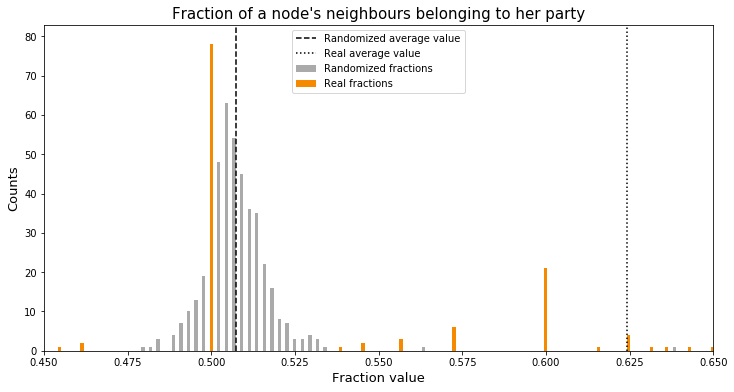

In [35]:
# Calculating the distribution:
v = np.linspace(min(min(rand_frac),min(frac)),max(max(rand_frac),max(frac)),rand_frac.size)
counts, bin_edges = np.histogram(rand_frac,v)
counts2, bin_edges2 = np.histogram(frac,v)

# Middle points of the bin-edges are calculated.
x_bins = [np.mean((bin_edges[i],bin_edges[i+1])) for i in range(len(bin_edges)-1)]
x_bins2 = [np.mean((bin_edges2[i],bin_edges2[i+1])) for i in range(len(bin_edges2)-1)]

# Figure creation
f = plt.figure(figsize=(12, 6))
ax = f.gca()

# Plots
plt.bar(x_bins,counts,color='#aaaaaa',alpha = 1.0,label='Randomized fractions', width=0.001)
plt.bar(x_bins2,counts2,color='#f58a00',alpha = 1.0,label='Real fractions', width=0.001)
plt.axvline(x=random_avg_frac,color='k',linestyle='--',label='Randomized average value')
plt.axvline(x=avg_frac,color='k',linestyle=':',label='Real average value')

# Plot options
plt.title('Fraction of a node\'s neighbours belonging to her party', fontsize=15)
plt.xlabel("Fraction value", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.xlim([0.45,0.65])
plt.legend()
plt.show()


<font color="#0B498F"> The chance to connect to a member of the same party is much higher in reality compared to when the parties are shuffled. This is however not surprising. It is reasonable to expect that there will be some grouping in the network diving the two parties into sub-components.

- __Compute the assortativity coefficient with respect to the party. How do you interpret the result?__

In [36]:
# Computing the coefficient
party_asst_coeff = nx.attribute_assortativity_coefficient(Gundir, 'party')
print("Assortativity coefficient with respect to the party: \t {:.3}".format(party_asst_coeff))

Assortativity coefficient with respect to the party: 	 0.288


<font color="#0B498F"> Assortativity is a measure of the tendency of a network's nodes to attach other nodes with which it shares some attribute. In the above case, party. A value greater than 0 means that the nodes in the network prefer to connect to nodes of the same party.

- __Repeat the exercise, but considering states instead of parties.__

In [37]:
# Computing the coefficient
state_asst_coeff = nx.attribute_assortativity_coefficient(Gundir, 'state')
print("Assortativity coefficient with respect to the state: \t {:.3}".format(state_asst_coeff))

Assortativity coefficient with respect to the state: 	 0.164


<font color="#0B498F"> We see here that the assortativity coefficient with respect to state is somewhat lower than that for state, implying that belonging to the same party is a greater measure of connection than is state.